# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.7281

947/947 [==============================] - 3550s 4s/step - loss: 0.8157 - accuracy: 0.7281 - val_loss: 0.7736 - val_accuracy: 0.7398
Epoch 2/200
947/947 [==============================] - 3006s 3s/step - loss: 0.7031 - accuracy: 0.7587 - val_loss: 0.9145 - val_accuracy: 0.7476
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7748

947/947 [==============================] - 3298s 3s/step - loss: 0.6490 - accuracy: 0.7748 - val_loss: 0.6950 - val_accuracy: 0.7593
Epoch 4/200
947/947 [==============================] - 3004s 3s/step - loss: 0.6177 - accuracy: 0.7813 - val_loss: 4.3938 - val_accuracy: 0.6452
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.7912

947/947 [==============================] - 3311s 3s/step - loss: 0.5917 - accuracy: 0.7912 - val_loss: 0.6314 - val_accuracy: 0.7735
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8013

947/947 [==============================] - 3281s 3s/step - loss: 0.5635 - accuracy: 0.8013 - val_loss: 0.5901 - val_accuracy: 0.7983
Epoch 7/200
947/947 [==============================] - 3010s 3s/step - loss: 0.5471 - accuracy: 0.8080 - val_loss: 0.6930 - val_accuracy: 0.7677
Epoch 8/200
947/947 [==============================] - 3000s 3s/step - loss: 0.5271 - accuracy: 0.8145 - val_loss: 0.7834 - val_accuracy: 0.7272
Epoch 9/200
947/947 [==============================] - 2998s 3s/step - loss: 0.5098 - accuracy: 0.8206 - val_loss: 0.6524 - val_accuracy: 0.7720
Epoch 10/200
947/947 [==============================] - 3020s 3s/step - loss: 0.4883 - accuracy: 0.8247 - val_loss: 0.5951 - val_accuracy: 0.7966
Epoch 11/200
947/947 [==============================] - 2996s 3s/step - loss: 0.4857 - accuracy: 0.8280 - val_loss: 1.4988 - val_accuracy: 0.6994
Epoch 12/200
947/947 [==============================] - 2996s 3s/step - loss: 0.4698 - accuracy: 0.8322 - val_loss: 0.6670 - val_accuracy: 0

947/947 [==============================] - 3262s 3s/step - loss: 0.4485 - accuracy: 0.8388 - val_loss: 0.5395 - val_accuracy: 0.8109
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.8442

947/947 [==============================] - 3266s 3s/step - loss: 0.4290 - accuracy: 0.8442 - val_loss: 0.4811 - val_accuracy: 0.8258
Epoch 15/200
947/947 [==============================] - 3035s 3s/step - loss: 0.4200 - accuracy: 0.8489 - val_loss: 0.5115 - val_accuracy: 0.8179
Epoch 16/200
947/947 [==============================] - 2997s 3s/step - loss: 0.4098 - accuracy: 0.8521 - val_loss: 0.5144 - val_accuracy: 0.8122
Epoch 17/200
947/947 [==============================] - 3003s 3s/step - loss: 0.3961 - accuracy: 0.8561 - val_loss: 0.5311 - val_accuracy: 0.8057
Epoch 18/200
947/947 [==============================] - 3009s 3s/step - loss: 0.3832 - accuracy: 0.8595 - val_loss: 0.4814 - val_accuracy: 0.8287
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.3680 - accuracy: 0.8666

947/947 [==============================] - 3274s 3s/step - loss: 0.3680 - accuracy: 0.8666 - val_loss: 0.4714 - val_accuracy: 0.8356
Epoch 20/200
947/947 [==============================] - 2996s 3s/step - loss: 0.3613 - accuracy: 0.8679 - val_loss: 0.5047 - val_accuracy: 0.8323
Epoch 21/200
947/947 [==============================] - 3035s 3s/step - loss: 0.3418 - accuracy: 0.8759 - val_loss: 0.4885 - val_accuracy: 0.8319
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.3315 - accuracy: 0.8770

947/947 [==============================] - 3272s 3s/step - loss: 0.3315 - accuracy: 0.8770 - val_loss: 0.4652 - val_accuracy: 0.8424
Epoch 23/200
947/947 [==============================] - 2999s 3s/step - loss: 0.3186 - accuracy: 0.8833 - val_loss: 0.4914 - val_accuracy: 0.8308
Epoch 24/200
947/947 [==============================] - 2997s 3s/step - loss: 0.3083 - accuracy: 0.8868 - val_loss: 0.5212 - val_accuracy: 0.8238
Epoch 25/200
947/947 [==============================] - 3003s 3s/step - loss: 0.2951 - accuracy: 0.8901 - val_loss: 0.4955 - val_accuracy: 0.8374
Epoch 26/200
947/947 [==============================] - 2997s 3s/step - loss: 0.2969 - accuracy: 0.8915 - val_loss: 0.6369 - val_accuracy: 0.8065
Epoch 27/200
947/947 [==============================] - 3002s 3s/step - loss: 0.2712 - accuracy: 0.9021 - val_loss: 0.5084 - val_accuracy: 0.8280
Epoch 28/200
947/947 [==============================] - 3001s 3s/step - loss: 0.2627 - accuracy: 0.9026 - val_loss: 0.4996 - val_accuracy

947/947 [==============================] - 3279s 3s/step - loss: 0.2314 - accuracy: 0.9124 - val_loss: 0.4524 - val_accuracy: 0.8544
Epoch 32/200
947/947 [==============================] - 3000s 3s/step - loss: 0.2291 - accuracy: 0.9169 - val_loss: 0.5083 - val_accuracy: 0.8342
Epoch 33/200
947/947 [==============================] - 3028s 3s/step - loss: 0.2217 - accuracy: 0.9175 - val_loss: 0.5057 - val_accuracy: 0.8481
Epoch 34/200
947/947 [==============================] - 2998s 3s/step - loss: 0.2091 - accuracy: 0.9213 - val_loss: 0.4984 - val_accuracy: 0.8441
Epoch 35/200
947/947 [==============================] - 3001s 3s/step - loss: 0.1943 - accuracy: 0.9276 - val_loss: 0.4980 - val_accuracy: 0.8418
Epoch 36/200
947/947 [==============================] - 2998s 3s/step - loss: 0.1933 - accuracy: 0.9278 - val_loss: 0.5858 - val_accuracy: 0.8361
Epoch 37/200
947/947 [==============================] - 3008s 3s/step - loss: 0.1858 - accuracy: 0.9313 - val_loss: 0.5222 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 310s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9600193845408287,
 'basal cell carcinoma': 0.989140037814606,
 'dermatofibroma': 0.9749158249158248,
 'melanoma': 0.9349382789141824,
 'nevus': 0.967915632856148,
 'pigmented benign keratosis': 0.9859718029959317,
 'seborrheic keratosis': 0.9533031340760327,
 'solar lentigo': 0.9821396147306911,
 'squamous cell carcinoma': 0.9784623536017334,
 'vascular lesion': 0.9971788046322207}

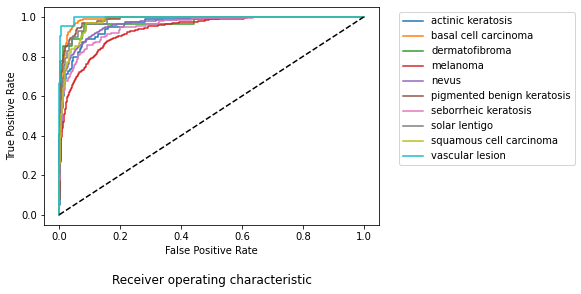

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

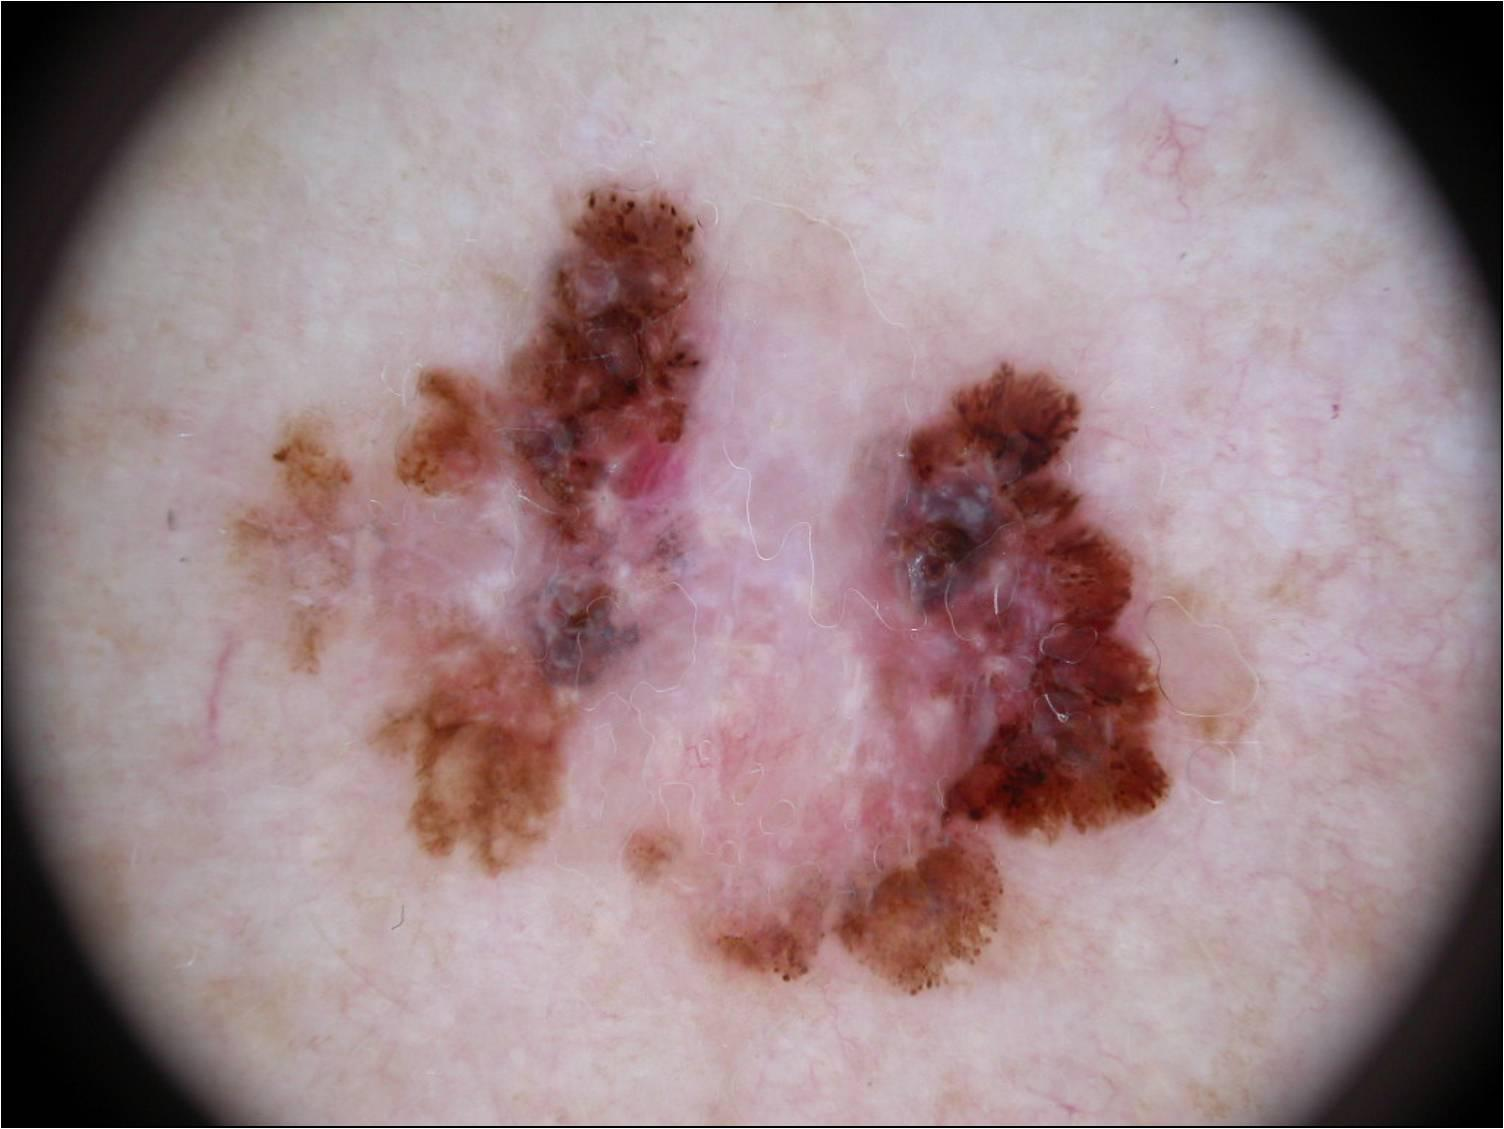

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

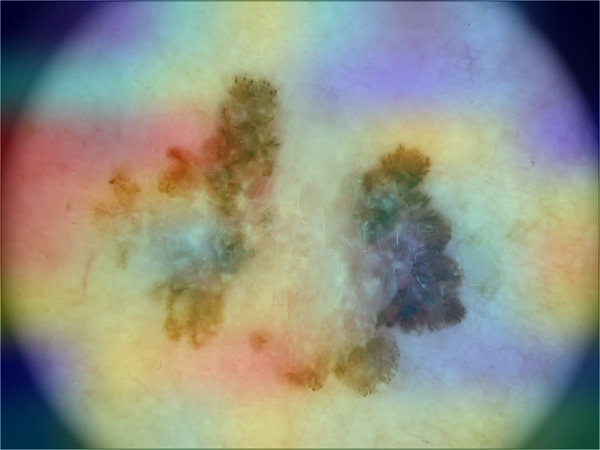

In [23]:
display_gradcam(melanoma_im_path, heatmap)